## Presentation

### Observations about the problem

- This problem is characterized by its vast state space and the scarcity of the reward that exists only when reaching the solved state if we don't introduce knowledge into the model. We could potentially introduce at one point a reward function that gives information about the quality of the current state.

- The system is deterministic and we know all the transitions of it. 

### We decide for now to not introduce any knowledge and have a reward of 1 if reaching the solved state and -1 else


### Important points on why we can't simply do Q Learning with this method:

1) We need the initial position to be close to the solved state else it will be impossible for the agent to get to this state (the only one giving a reward) given the extremely vast state space.
    -> We take as a distance to the solved state the number of random shuffles that are done from it.

2) The system is completely deterministic and we know all the transitions. It is thus better to work by updating the state_values instead of the q_values as it is 6x smaller (6 actions possible for a 2x2 rubiks cube).

3) We can't do full episodes as if the agent explores / goes into an unseen part of the rubiks cube he is very likely to get "lost" in it and do thousands of iterations before arriving to the solved state if it even reaches it. 



### The solution ADI (Auto Didactic Iteration) (https://arxiv.org/pdf/1805.07470.pdf)

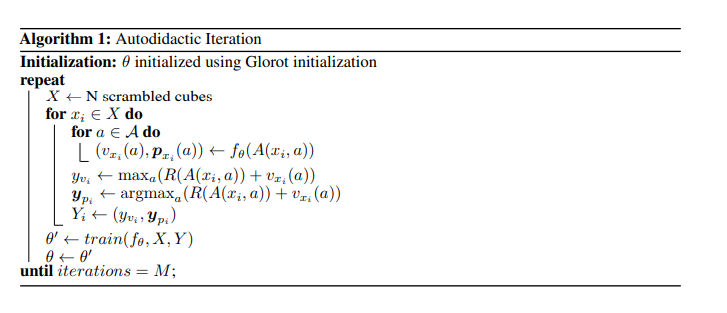

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Callable
from cube import CubeEnv

In [8]:
# Setup cuda/cpu device
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
#device=torch.device("cpu")
print(f"PyTorch will train neural networks on {device}")

False
PyTorch will train neural networks on cpu


## Environment

In [9]:
env = CubeEnv(device=device,render_mode="rgb_array")
env.reset()
states = [env.state]
for i in range(10):
    env.step(env.action_space.sample())
    states.append(env.state)
#env.animate_frames(states)

Simple checks made to check that rotations work and that they are able to cancel each other when performed successively. Reward function can also be checked here

Reward with 2 solves faces: -1
Reward of solved cube: 1


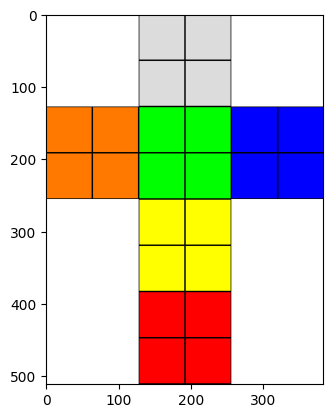

In [10]:
env.reset()
env._face_rotation(0, 1)
print("Reward with 2 solves faces:", env.reward(env.state))
env._face_rotation(0, -1)
print("Reward of solved cube:", env.reward(env.state))
env.render()

## DNN-Based Controler

In [11]:
n_input  = 6 * 6 * env.size * env.size # 6 = nombre de faces // size^2 = nombre de couleurs par face // 6 = one-hot encoding des couleurs
n_dense  = 256 # au pif, un pax avait choisi 1024 pour le 3x3

class ADINetwork(torch.nn.Module):
    def __init__(self):
        super(ADINetwork, self).__init__()
        
        self.l1 = nn.Linear(n_input, n_dense)
        self.l2=nn.Linear(n_dense, n_dense)
        self.l3 = nn.Linear(n_dense, 1)
        self.l4 = nn.Linear(n_dense, 6)
        self.softmax = nn.Softmax(dim=1)
        self.elu = nn.ELU()
        self.batch_norm = nn.InstanceNorm1d(n_dense)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.l1(x)
        x = self.elu(x)
        x = self.l2(x)
        x= self.batch_norm(x)
        x = self.elu(x)
        x1 = self.l3(x)
        x1 = self.elu(x1)
        x2 = self.l4(x)
        #x2=self.softmax(x2)
        x = torch.cat((x1, x2), 1)
        return x

## Policies

ADI does not make use of any policy. It is only being used after the training phase, when trying to solve the cube

In [12]:
class GreedyPolicy :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,max_iter=20):
        self.adi_network = adi_network
        self.env=env
        self.max_iter=max_iter
    def __call__(self) -> int:
        states=[self.env._get_obs()]
        actions=[]
        for i in range(self.max_iter) :
            with torch.no_grad():
                action=torch.argmax(self.adi_network(self.env._get_obs().unsqueeze(0))[0][1:]).item()
            _,_,done,_,_=self.env.step(action)
            states.append(self.env._get_obs())
            actions.append(action)
            if done:
                break
        return done,states,actions

In [15]:
class BeamSearch :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,beam_width:int,max_iter=20):
        self.adi_network = adi_network
        self.beam_width=beam_width
        self.env=env
        self.max_iter=max_iter
    
    def __call__(self) -> int:
        considered_states=[(1,env._get_obs().unsqueeze(0),[],[])]
        depth=0
        while True:
            new_considered_states=[]
            for score,state,past_states,past_actions in considered_states :
                probas=torch.nn.Softmax()(self.adi_network(state)[0][1:])
                for i,proba in enumerate(probas) :
                    next_state_tensor,reward,done,_,_ =env.simulate_step(state.squeeze(),i)
                    next_state_tensor=next_state_tensor.unsqueeze(0)
                    state_to_consider=(score*proba.item(),next_state_tensor,past_states+[state],past_actions+[i])
                    new_considered_states.append(state_to_consider)
                    if done or depth==self.max_iter:
                        return done,state_to_consider[2]+[state],state_to_consider[3]+[i]
            depth+=1
                    
            #We keep only the beam_width best states
            considered_states=sorted(new_considered_states,key=lambda x : x[0],reverse=True)[:self.beam_width]

In [16]:
class UCB :
    def __init__(self,adi_network: torch.nn.Module,env: CubeEnv,confidence:float,max_iter=20):
        self.adi_network = adi_network
        self.env=env
        self.max_iter=max_iter
        self.confidence=confidence
        

    def __call__(self) -> int:
        #Here we define a node by the actions that were taken to arrive to it
        visits={(0,):1}
        values={}
        t=0
        while True :
            actions=[0]
            states=[self.env._get_obs()]
            done=False
            #One pass through the tree
            #Start at the root
            while not self._is_leaf(actions,visits) and not done:
                visits[tuple(actions)]+=1
                action_ucb=[]
                for next_action in range(6) :
                    updated_actions=tuple(actions+[next_action])
                    value_term=values[updated_actions]
                    exploratory_term=self.confidence*np.sqrt(np.log(t)/(1+visits[updated_actions]))
                    action_ucb.append(value_term+exploratory_term)
                next_action=np.argmax(action_ucb)
                actions.append(next_action)
                next_state,_,done,_,_=self.env.simulate_step(states[-1],next_action)
                states.append(next_state)

            if len(actions)==self.max_iter or done:
                return done,states,actions
            #When arriving at a leaf node, we explore it
            with torch.no_grad() :
                next_action_values=self.adi_network(states[-1].unsqueeze(0))[0][1:]
            
            for next_action in range(6) :
                updated_actions=tuple(actions+[next_action])
                values[updated_actions]=next_action_values[next_action].item()
                visits[updated_actions]=1
            visits[updated_actions]+=1
            t+=1
            if t>100:
                return False,[],[]
        

    def _is_leaf(self, actions,visits) :
        return tuple(actions+[0]) not in visits

## Learning rate scheduler

In [13]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

## Train function

In [14]:
class TargetValue:
    def __init__(self, adi_network: torch.nn.Module):
        self.adi_network = adi_network

    def __call__(self, env: CubeEnv,states:torch.tensor=None) -> np.int64:
        batch_size = states.shape[0]
        batched_action = torch.zeros(states.shape[0],dtype=torch.int64,device=device)
        batched_values = torch.zeros(states.shape[0],7,device=device)
        for i in range(batch_size):
            state_tensor=states[i]
            state=env.from_tensor_to_state(state_tensor)
            state_values = []
            for a in range(6) :
                next_state_tensor,reward,_,_,_ =env.simulate_step(state,a)
                next_state_tensor=next_state_tensor.unsqueeze(0)
                with torch.no_grad():
                    state_values.append(reward+self.adi_network(next_state_tensor)[0][0])
            state_values=torch.tensor(state_values,device=device)
            action = torch.argmax(state_values).item()
            batched_action[i]=action
            value=torch.zeros(7)
            value[action+1]=1
            value[0]=state_values[action]
            batched_values[i]=value
        return batched_values

In [15]:
#TODO: Include batch size
def train_adi(env: CubeEnv,
                     adi_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     state_loss_fn: Callable,
                     action_loss_fn: Callable,
                     target_value_gen: TargetValue,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     batch_size: int,
                     num_episodes,
                     num_shuffles: int, #How deep we shuffle the rubiks cube
                     ) -> List[float]:
    iteration = 0
    losses = []
    for episode in tqdm(range(0, num_episodes, batch_size)) :
        env.reset()
        states = env.shuffle(num_shuffles, batch_size=batch_size)
        loss=0
        #The first dimension of states corresponds to the shuffle steps.(num_shuffles,batch_size,n_input)
        for n_shuffle,shuffle_step in enumerate(states) :
            target_value=target_value_gen(env,shuffle_step)
            estimated_value=adi_network(shuffle_step)
            #Rescaling by 1/(n_shuffle+1) to avoid divergence of the value esimation.
            #Weight of 0.3 for the value_loss (=Estimation of the value of the state)
            #Weight of 0.7 for the action_loss (=Estimation of the action to take)
            loss +=  0.3/(n_shuffle+1)*state_loss_fn(estimated_value[:,0], target_value[:,0])+0.7*action_loss_fn(estimated_value[:,1:], target_value[:,1:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        iteration += 1
        losses.append(loss.item()/num_shuffles)
        if episode % 128 == 0:
            print(f"Episode {episode} - Loss: {losses[-1]} - {estimated_value[0][0]} - {target_value[0][0]}")
    
    return losses


## Train it

In [16]:
num_episodes = 1024
batch_size   = 8
num_shuffles = 8
adi_network  = ADINetwork().to(device) # adi network

optimizer = torch.optim.AdamW(adi_network.parameters(), lr=0.01, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
state_loss_fn = torch.nn.MSELoss()
action_loss_fn = torch.nn.CrossEntropyLoss()
target_value = TargetValue(adi_network=adi_network)

# Train the adi network
losses = train_adi(env,
                   adi_network,
                   optimizer,
                   state_loss_fn,
                   action_loss_fn,
                   target_value,
                   device,
                   lr_scheduler,
                   batch_size,
                   num_episodes,
                   num_shuffles)

# Save the action-value estimation function
torch.save(adi_network, "adi_network_hk_wout.pth")

  0%|          | 0/128 [00:00<?, ?it/s]

c:\Users\Jules\git\INF581_Cube\cube.py:403: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(batched_obs, device=self.device)
c:\Users\Jules\git\INF581_Cube\venv\lib\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Episode 0 - Loss: 1.3199535608291626 - -0.5101252794265747 - -1.0030696392059326
Episode 128 - Loss: 1.106041669845581 - 19.57561683654785 - 19.013486862182617
Episode 256 - Loss: 0.9106297492980957 - 29.062881469726562 - 29.685047149658203
Episode 384 - Loss: 0.980451762676239 - 40.34300231933594 - 40.09281921386719
Episode 512 - Loss: 0.8604158163070679 - 47.27777862548828 - 47.62102508544922
Episode 640 - Loss: 0.9404635429382324 - 52.3992919921875 - 51.7945442199707
Episode 768 - Loss: 0.8319840431213379 - 54.12767028808594 - 53.63170623779297
Episode 896 - Loss: 0.7123812437057495 - 54.65389633178711 - 55.11932373046875


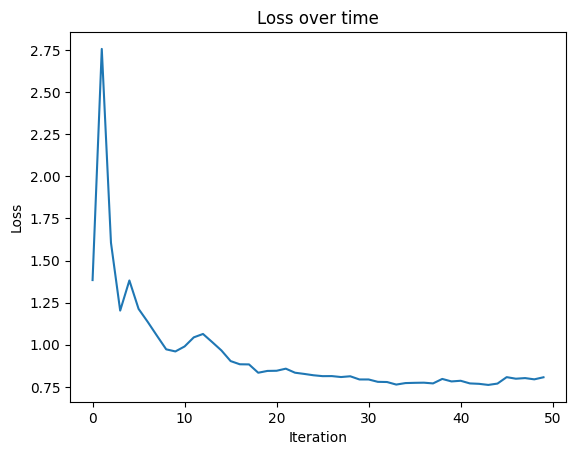

In [ ]:
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Execute the following code to load the pretrained model

In [4]:
# Load a pretrained model
adi_network = torch.load("adi_network.pth", map_location=torch.device('cpu')).to(device)
#adi_network = torch.load("adi_network.pth").to(device)

NameError: name 'torch' is not defined

Periodicity of the loss as we shuffle (from 1 shuffle to n shuffle and then back to 1 shuffle ...).

True
6
[5, 5, 3, 4, 1, 1]


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

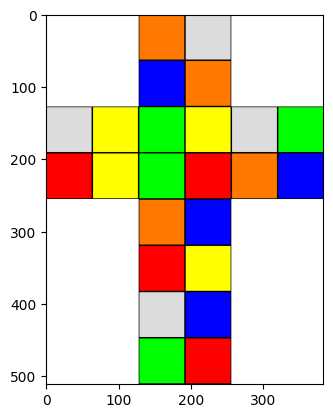

In [306]:
beam_search = BeamSearch(adi_network, env, 10)
env.reset(9)
done, states, actions = beam_search()
#print(done, len(states), actions)
env.render()

MovieWriter ffmpeg unavailable; using Pillow instead.


......

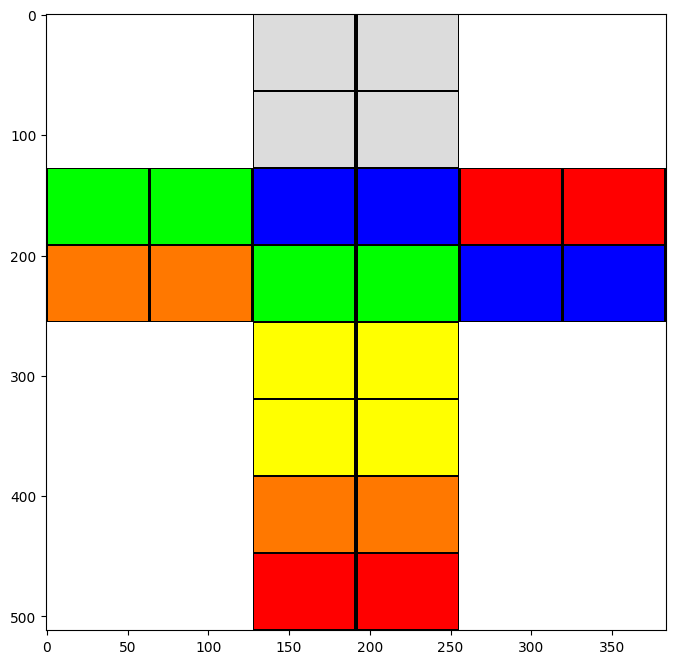

In [277]:
env.animate_frames([env.from_tensor_to_state(state) for state in states])

## Accuracy metric
Accuracy is the percentage of n-shuffles of a cube an agent is capable of fully solving given a set number of moves before giving up. We calculate accuracy for a few policies with samples of 50 3-shuffles.

In [17]:
def compute_accuracy(env, n_samples, n_shuffles, policy) :
    success = 0
    for _ in range(n_samples):
        env.reset(n_shuffles)
        solved, _, _ = policy()
        if solved:
            success += 1
    return success / n_samples

def plot_accuracy(env, n_samples, max_shuffles, policies):
    for policy in policies:
        accs = []
        for i in tqdm(range(1,max_shuffles+1)) :
            acc=compute_accuracy(env,n_samples,i,policy)
            accs.append(acc)
        plt.plot(list(range(1,max_shuffles+1)),accs,label=policy.__class__.__name__)
        plt.xlabel("Number of shuffles")
        plt.ylabel("Accuracy")
        plt.title("Accuracy of various policies")
    
    plt.legend()
    plt.show() 

Print accuracies of different policies on a sample of 50 different 3-shuffles

  0%|          | 0/8 [00:00<?, ?it/s]

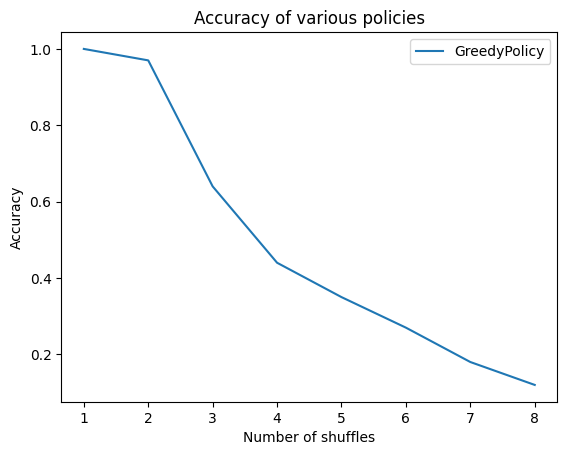

In [23]:
policies = [
    GreedyPolicy(adi_network, env),
    #BeamSearch(adi_network, env, 10),
    #UCB(adi_network, env, confidence=2),
]

plot_accuracy(env, 100, 8, policies)

Check the difference between a model trained with human knowledge based reward vs model without human knowledge. Test is made against a simple greedy policy with minimally trained models (1024 episodes, batch size of 8). Metrics on 1- up to 8-shuffles, samples of 100 shuffles.

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

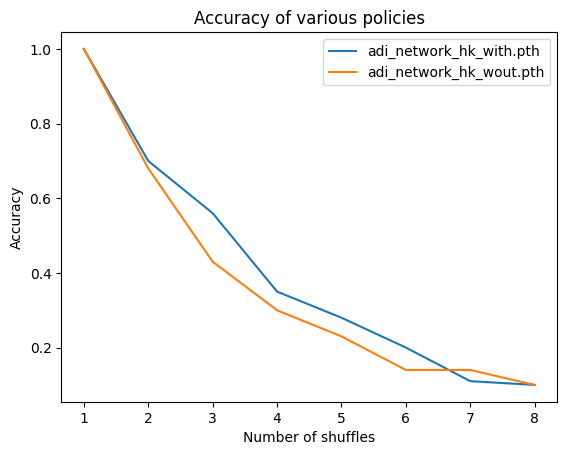

In [18]:
n_samples = 50
policy = GreedyPolicy(adi_network, env)
max_shuffles = 8
for model_name in ['adi_network_hk_with.pth', 'adi_network_hk_wout.pth']:
    adi_network = torch.load(model_name, map_location=torch.device('cpu')).to(device)
    accs = []
    for i in tqdm(range(1, max_shuffles + 1)):
        accs.append(compute_accuracy(env, n_samples, i, policy))
    plt.plot(list(range(1, max_shuffles + 1)), accs, label=model_name)

plt.xlabel("Number of shuffles")
plt.ylabel("Accuracy")
plt.title("Giving human knowledge to agent")
plt.legend()
plt.show() 